## Introdução

O presente problema se refere aos dados de vinhos portugueses
"Vinho Verde", que possuem variantes de vinho branco e tinto.
Devido a questões de privacidade, apenas variáveis
físico-químicas (input) e sensoriais (output) estão disponíveis (por
exemplo, não há dados sobre tipo de uva, marca do vinho, preço
de venda, etc).

**Objetivo**
Criar um modelo para estimar a qualidade do vinho.



In [1]:
pip install h2o

### Iniciando a execução

A importação das bicliotecas ou pacotes Python estão nas linhas de comando abaixo.

* Pandas para manipulação de dados em formato de Data Frame
* Seaborn para criação de gráficos mais elaborados e com maior qualidade visual
* Numpy é um pacote que suporta arrays e matrizes multidimensionais
* Matplotlib é a biblioteca gráfica de base usada em cojunto com Seaborn
* ipywidgets para interação com Jupyter Notebook
* H2O é uma plataforma de aprendizado de máquina e análise preditiva de código aberto, na memória, distribuída, rápida e escalonável, que permite criar modelos de aprendizado de máquina em big data e fornece fácil produção desses modelos em um ambiente corporativo


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline 
import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvzhfqrzx
  JVM stdout: /tmp/tmpvzhfqrzx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvzhfqrzx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_aqm1ql
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


### Leitura do arquivo fonte


![default of credit card clients Data Set](https://archive.ics.uci.edu/ml/assets/logo.gif)

[Arquivo Original](http://archive.ics.uci.edu/ml/datasets/Wine+Quality)

Não usamos o arquivo original. O motivo será explicado no final desse documento.
Nesse passo é importante ter acesso à Internet, pois o arquivo está sendo lido diretamente do Github.

NOTA: esse arquivo foi enviado pelo solicitante que aqui supriremos o nome por questões de sigilo do processo.

In [0]:
dfo = pd.read_csv('https://raw.githubusercontent.com/dbranquinho/wine/master/winequality.csv', sep=';')

### Transformações

Faremos aqui algumas transformações para deixar mais claro as variáveis envolvidas.

Abaixo temos parte dos dados expostos. Observamos que a variável *quality* é a nossa variável alvo. 

Variáveis input (baseado em testes físico-químicos):
1. Tipo
2. Acidez fixa
3. Volatilidade da acidez
4. Ácido cítrico
5. Açúcar residual
6. Cloretos
7. Dióxido de enxofre livre
8. Dióxido de enxofre total
9. Densidade
10. pH
11. Sulfatos
12. Álcool

Variável output (baseado em dado sensorial):
13. Qualidade (score entre 0 and 10)

As variáveis tem nomes separados por espaços, faremos uma pequena transformação para evitar possíveis problemas de tokenização.

In [4]:
dfo.head()


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [0]:
dfo.rename({'fixed acidity': 'fixed_acidity',
           'volatile acidity': 'volatile_acidity', 
           'citric acid': 'citric_acid', 
           'residual sugar': 'residual_sugar', 
           'free sulfur dioxide': 'free_sulfur_dioxide', 
           'total sulfur dioxide': 'total_sulfur_dioxide'}, 
           axis=1, inplace=True)

**Dados ou linha duplicadas**

Vamos verificar se há linhas duplicadas nesse dataset.
Esse é um passo de limpeza e preparação de dados.

In [6]:
duplicateRowsDF = dfo[dfo.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

Duplicate Rows except first occurrence based on all columns are :
       type  fixed_acidity  volatile_acidity  ...  sulphates  alcohol  quality
4     White            7.2             0.230  ...       0.40      9.9        6
5     White            8.1             0.280  ...       0.44     10.1        6
7     White            7.0             0.270  ...       0.45      8.8        6
8     White            6.3             0.300  ...       0.49      9.5        6
20    White            6.2             0.660  ...       0.39     12.8        8
...     ...            ...               ...  ...        ...      ...      ...
6461    Red            7.2             0.695  ...       0.54     10.1        5
6462    Red            7.2             0.695  ...       0.54     10.1        5
6465    Red            7.2             0.695  ...       0.54     10.1        5
6479    Red            6.2             0.560  ...       0.60     11.3        5
6494    Red            6.3             0.510  ...       0.75     

In [7]:
dfo.shape

(6497, 13)

Temos $1177$ obervações duplicadas, vamos excluí-las, pois isso pode enviesar (criar bias) os resultados atribuindo pesos para determinadas classes em detrimento de outras.

---




In [0]:
dfo = dfo.drop_duplicates(ignore_index=True)

In [9]:
dfo.shape

(5320, 13)

Reindexando para eliminar linhas com "NaN" removidas.


In [0]:
dfo = dfo.reindex(range(0,dfo.shape[0]))

Vamos verificar que tipos de variáveis nos temos

In [11]:
dfo.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                  object
quality                   int64
dtype: object

Parece que o arquivo original foi alterado, pois a variável alcohol é do tipo categorica. Vamos verificar o que aconteceu com essa variável e ver seu conteúdo. Quais valores únicos existem.

In [12]:
dfo['alcohol'].unique()

array(['8.8', '9.5', '10.1', '9.9', '9.6', '11', '12', '9.7', '10.8',
       '12.4', '11.4', '12.8', '11.3', '10.5', '9.3', '10', '10.4',
       '11.6', '12.3', '10.2', '9', '11.2', '8.6', '9.4', '9.8', '11.7',
       '10.9', '9.1', '8.9', '10.3', '12.6', '10.7', '12.7', '10.6',
       '9.2', '8.7', '11.5', '11.8', '12.1', '11.1', '8.5', '12.5',
       '11.9', '12.2', '12.9', '13.9', '14', '13.5', '13.3', '13.2',
       '13.7', '13.4', '13', '8', '13.1', '8.0', '13.6', '8.4', '14.2',
       '11.94', '128.933.333.333.333', '114.666.666.666.667', '10.98',
       '100.333.333.333.333', '114.333.333.333.333',
       '105.333.333.333.333', '953.333.333.333.333',
       '109.333.333.333.333', '113.666.666.666.667',
       '113.333.333.333.333', '110.666.666.666.667',
       '973.333.333.333.333', '11.05', '9.75', '11.35', '9.55', '10.55',
       '11.45', '14.05', '123.333.333.333.333', '12.75', '13.8', '12.15',
       '13.05', '112.666.666.666.667', '105.666.666.666.667',
       '117.333.333

Há uma distorção nos valores originais do dataset. Vamos corrigir essa distorção assumindo que são dízimas periódicas.

In [0]:
myvar = dfo["alcohol"].copy()

In [0]:
for i in range(0,myvar.shape[0]):
    if myvar[i].count('.') > 2:
       myvar[i] = myvar[i].split('.')[0]+'.'+myvar[i].split('.')[1]

In [0]:
dfo["alcohol"] = myvar.copy()

In [16]:
dfo['alcohol'].unique()

array(['8.8', '9.5', '10.1', '9.9', '9.6', '11', '12', '9.7', '10.8',
       '12.4', '11.4', '12.8', '11.3', '10.5', '9.3', '10', '10.4',
       '11.6', '12.3', '10.2', '9', '11.2', '8.6', '9.4', '9.8', '11.7',
       '10.9', '9.1', '8.9', '10.3', '12.6', '10.7', '12.7', '10.6',
       '9.2', '8.7', '11.5', '11.8', '12.1', '11.1', '8.5', '12.5',
       '11.9', '12.2', '12.9', '13.9', '14', '13.5', '13.3', '13.2',
       '13.7', '13.4', '13', '8', '13.1', '8.0', '13.6', '8.4', '14.2',
       '11.94', '128.933', '114.666', '10.98', '100.333', '114.333',
       '105.333', '953.333', '109.333', '113.666', '113.333', '110.666',
       '973.333', '11.05', '9.75', '11.35', '9.55', '10.55', '11.45',
       '14.05', '123.333', '12.75', '13.8', '12.15', '13.05', '112.666',
       '105.666', '117.333', '11.75', '10.65', '109.666', '101.333',
       '10.15', '104.666', '116.333', '12.25', '11.85', '11.65', '13.55',
       '131.333', '11.95', '120.666', '11.55', '963.333', '12.05', '14.9',
       '

Ainda assim os valores maiores que 100 parecem ter sido criados artificialmente.
Não podemos alterar esses valores dividindo-os por 10, pois não evidências do fato. Não estamos comparando com o arquivo original que não possue esses valores, mas estamos respeitando a amostra enviada. Estamos apenas na fase de preparação dos dados para uma melhor modelagem.

Agora vamos transformar essa variável categorica para float.

In [0]:
dfo['alcohol'] = pd.to_numeric(dfo['alcohol'])

In [18]:
dfo.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

As  dimensões da amostra são:
* 5320 observações
* 12 características

In [19]:
dfo.shape

(5320, 13)

**Verificação de dados ausentes**

Veremos que não há dados ausentes. É muito importante porque o tratamento de limpeza deste não é necessário.

In [20]:
total = dfo.isnull().sum().sort_values(ascending = False)
percent = (dfo.isnull().sum()/dfo.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,quality,alcohol,sulphates,pH,density,total_sulfur_dioxide,free_sulfur_dioxide,chlorides,residual_sugar,citric_acid,volatile_acidity,fixed_acidity,type
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Verificando classes desequilibradas**

Vamos verificar o desequilíbrio dos dados em relação ao valor-alvo, ou seja, **quality**.

Os dados apresentam um grande desequilíbrio com relação ao valor alvo (quality), mas **Sim**, as classes são muito desequilibradas, portanto, o parâmetro que será usado em *H2O* deve obtê-lo usando Bagging.

*Bootstrap Aggregating*, também chamada de *bagging*, é um meta-algoritmo de conjunto de aprendizado de máquina projetado para melhorar a estabilidade e a precisão dos algoritmos de aprendizado de máquina usados na classificação e regressão estatística. Também reduz a variação e ajuda a evitar ajustes excessivos (*overfitting*). 

Embora geralmente seja aplicado aos métodos da árvore de decisão, ele pode ser usado com qualquer tipo de método. O *bagging* é um caso especial da abordagem de média do modelo.

[Wiki](https://en.wikipedia.org/wiki/Bootstrap_aggregating)

Vamos ver quantas classes temos

In [21]:
dfo.quality.unique()

array([6, 5, 7, 8, 4, 3, 9])

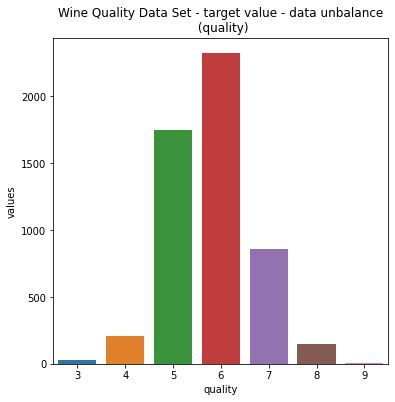

In [22]:
temp = dfo["quality"].value_counts()
df = pd.DataFrame({'quality': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Wine Quality Data Set - target value - data unbalance\n (quality)')
sns.set_color_codes("pastel")
sns.barplot(x = 'quality', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

Vamos melhorar essa abordagem para saber se um vinho é bom ou ruim.

Agora estamos verificando correlações. É uma parte importante do processo exploratório de análise de dados. Essa análise é um dos métodos usados para decidir quais recursos afetam mais a variável de destino e, por sua vez, são usados na previsão dessa variável de destino. Em outras palavras, é um método comumente usado para seleção de recursos no aprendizado de máquina.

As correlações são úteis porque podem indicar um relacionamento preditivo que pode ser explorado na prática. Veja o gráfico abaixo para ver todas as correlações entre os recursos. Existem fortes correlações entre pagamentos. Todos os outros são fragilidade.

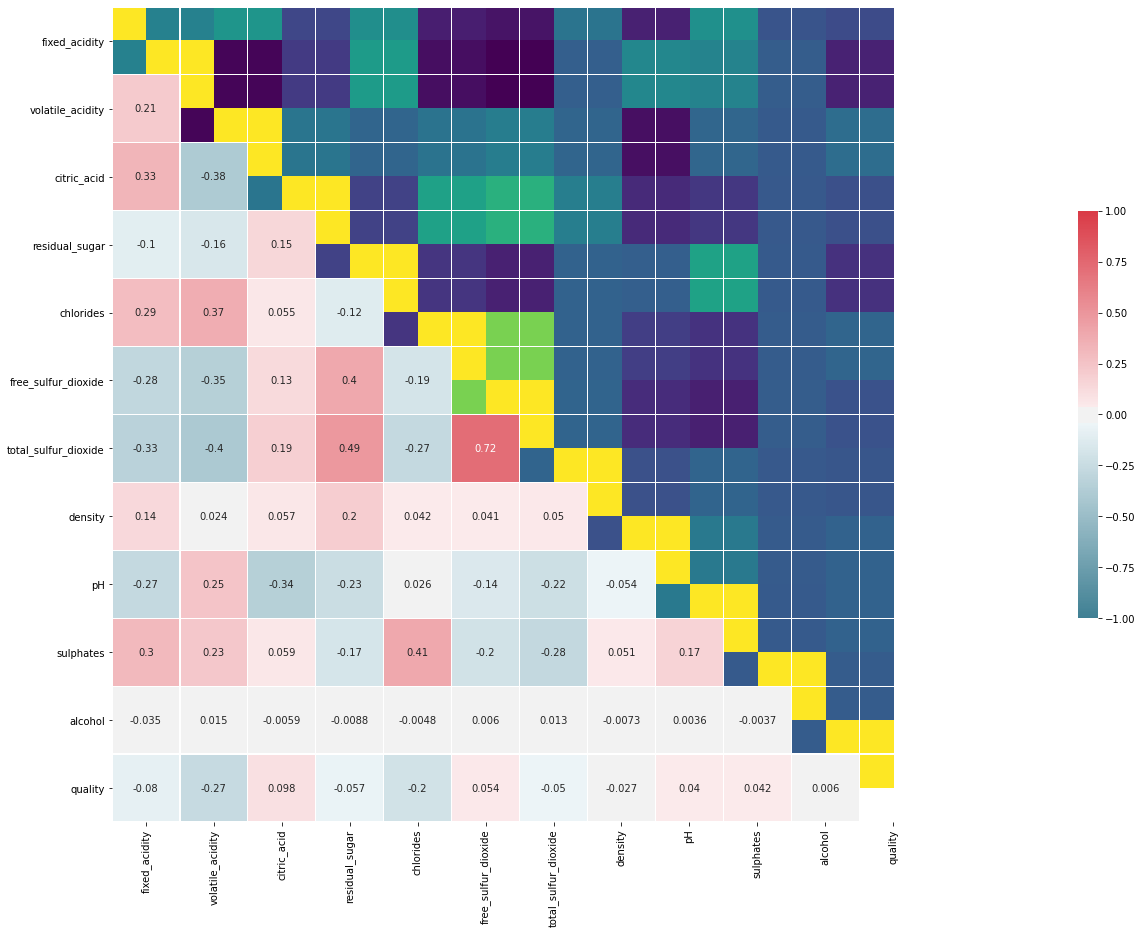

In [23]:
corr = dfo.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(54, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1,center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.imshow(corr)

Podemos ver o mesmo fenômeno sobre o par abaixo. correlação fraca entre a maioria dos recursos, mas forte correlação entre contas e pagamentos.

* Para os valores numéricos, vamos representar a correlação de recursos.
* A correlação está diminuindo com a distância entre meses. As correlações mais baixas são entre setembro e abril.
* Não há correlações entre os valores dos pagamentos anteriores de abril a setembro de 2005.
* A correlação está diminuindo com a distância entre meses. As correlações mais baixas são entre setembro e abril.

**Veja abaixo**


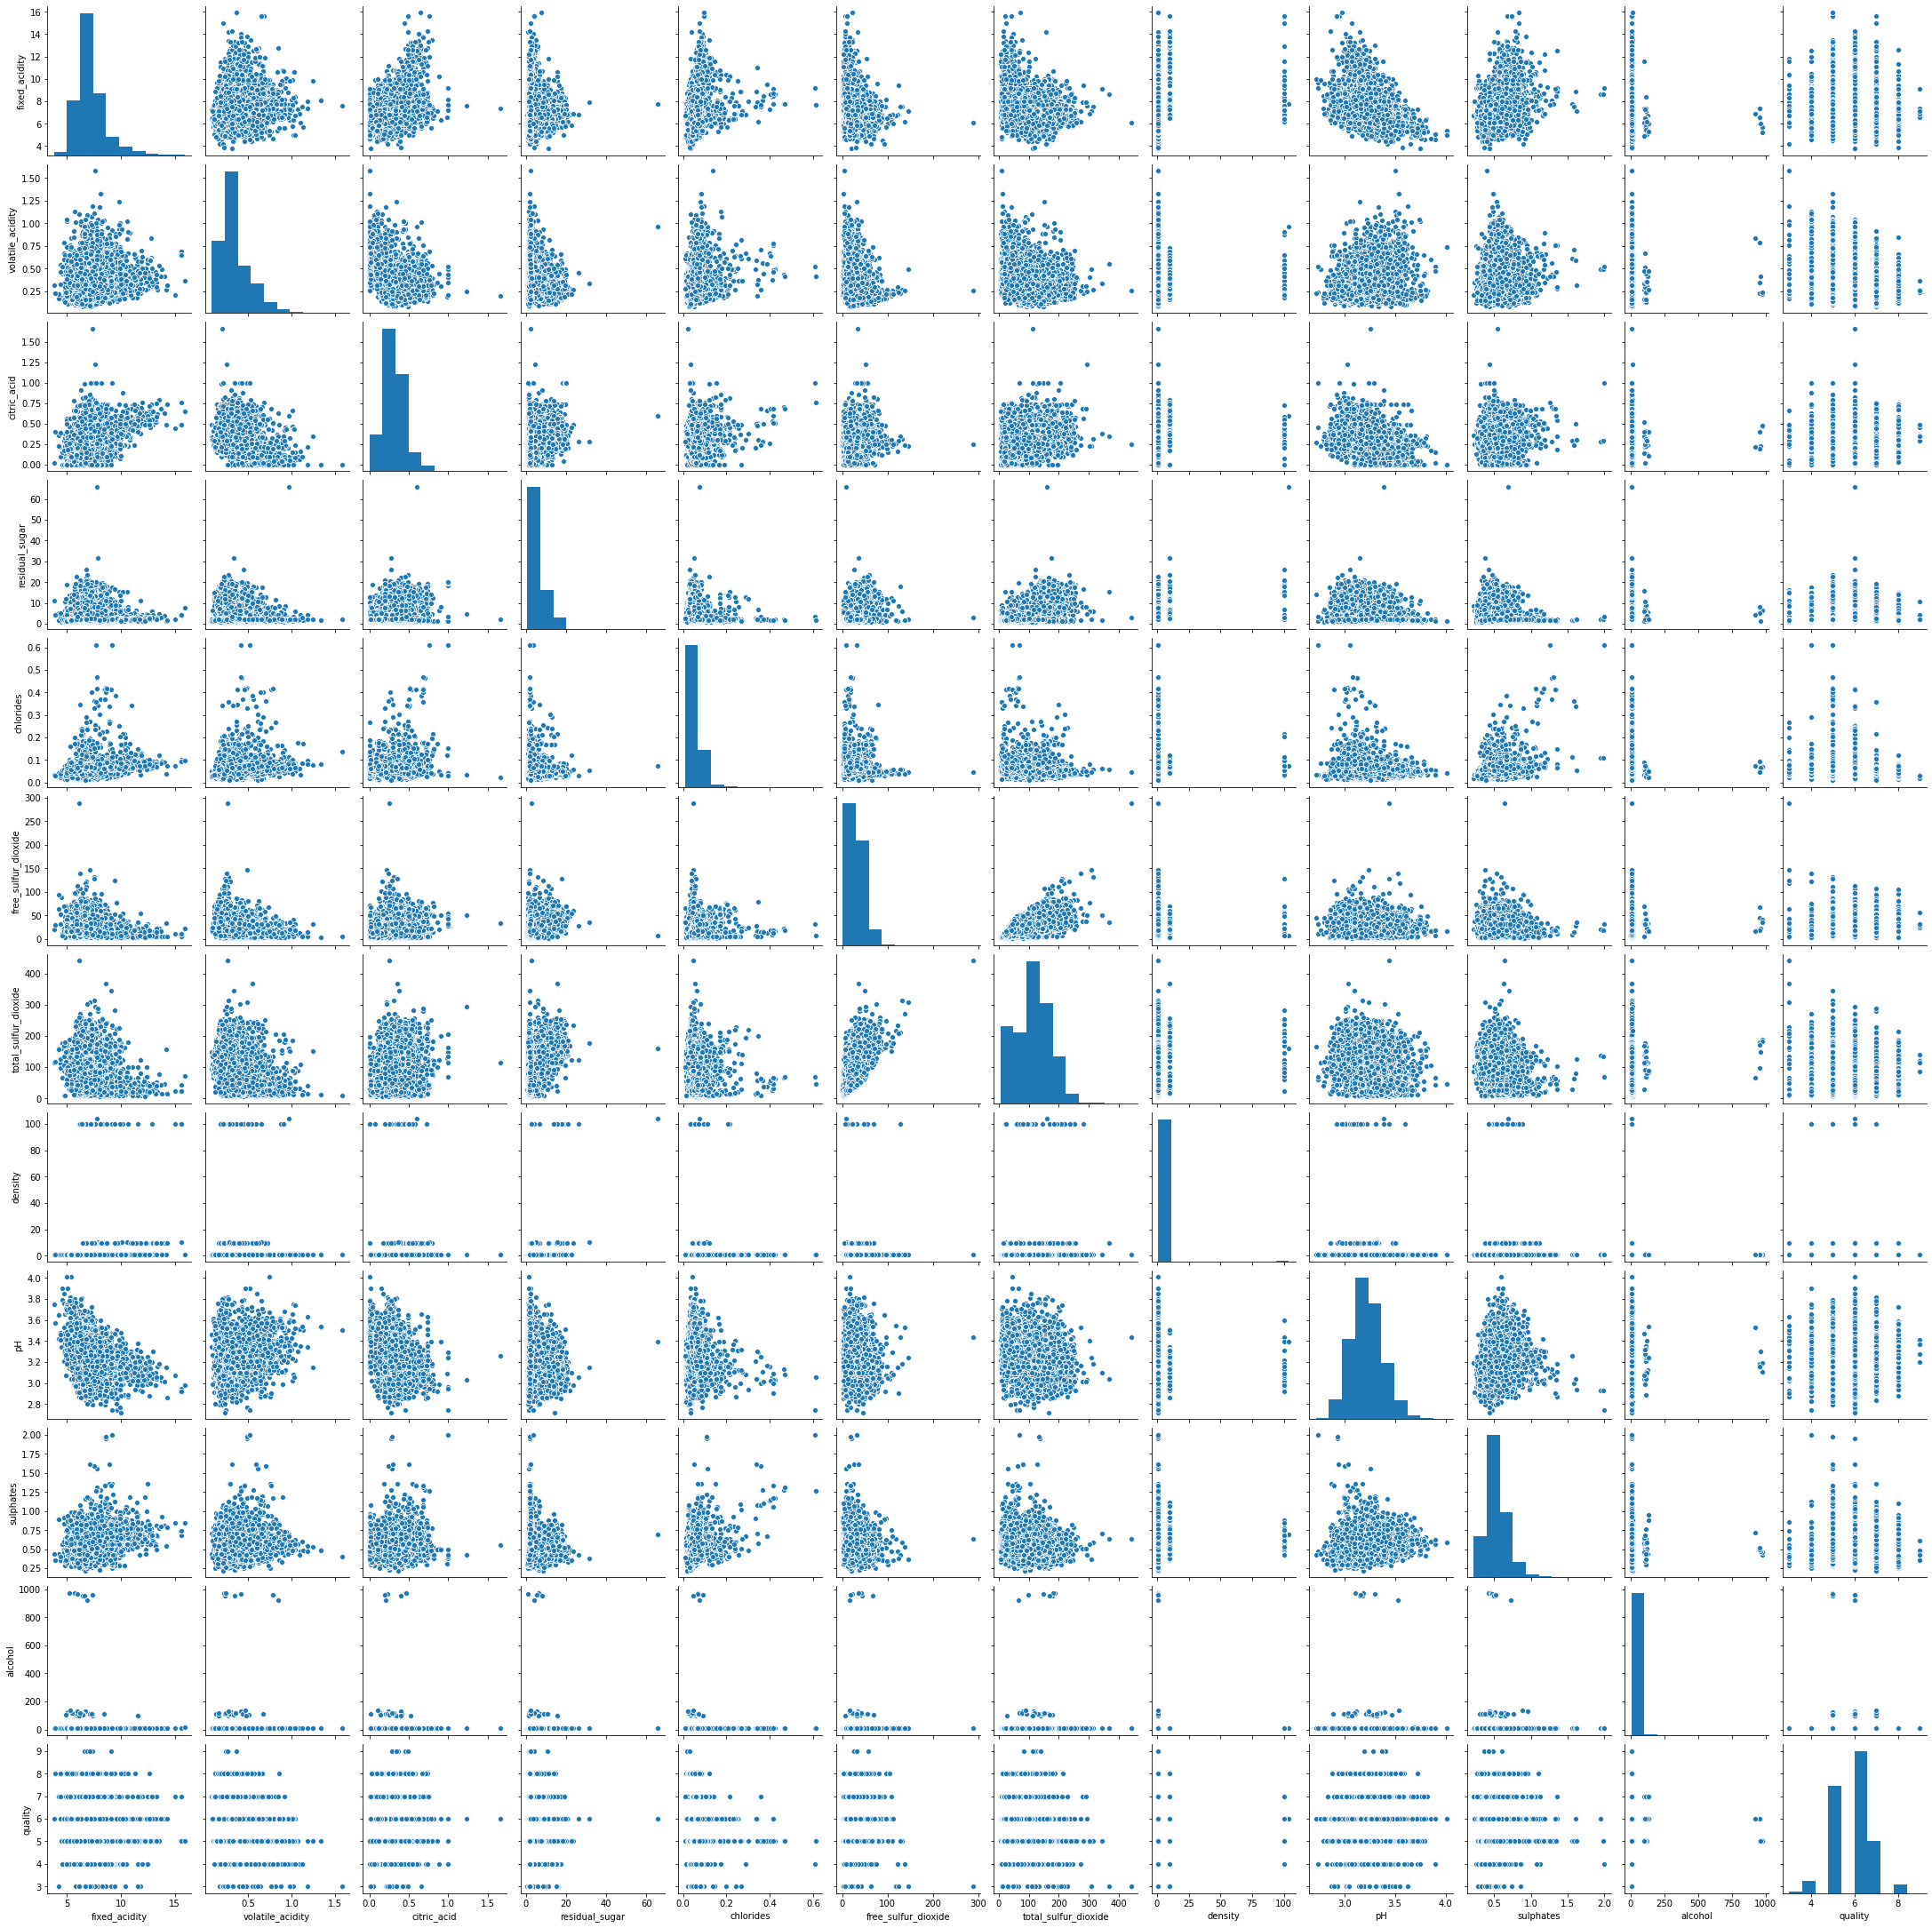

In [24]:
sns.pairplot(dfo)

### Valor do limite de crédito 

Vamos visualizar o gráfico de densidade para o valor do tipo de vinho agrupado por **quality**.

In [0]:
dfo['type'] = dfo['type'].map({'White': 1,'Red': 2}) 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


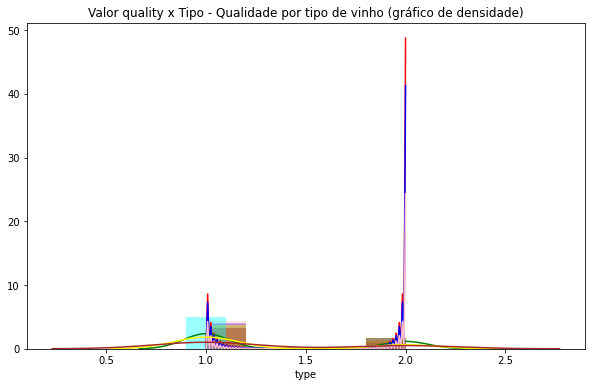

In [26]:

class_6 = dfo.loc[dfo['quality'] == 6]["type"]
class_5 = dfo.loc[dfo['quality'] == 5]["type"]
class_7 = dfo.loc[dfo['quality'] == 7]["type"]
class_8 = dfo.loc[dfo['quality'] == 8]["type"]
class_4 = dfo.loc[dfo['quality'] == 4]["type"]
class_3 = dfo.loc[dfo['quality'] == 3]["type"]
class_9 = dfo.loc[dfo['quality'] == 9]["type"]

plt.figure(figsize = (10,6))
plt.title('Valor quality x Tipo - Qualidade por tipo de vinho (gráfico de densidade)')
sns.set_color_codes("pastel")
sns.distplot(class_6,kde=True,bins=5, color="red")
sns.distplot(class_5,kde=True,bins=5, color="green")
sns.distplot(class_7,kde=True,bins=5, color="blue")
sns.distplot(class_8,kde=True,bins=5, color="pink")
sns.distplot(class_4,kde=True,bins=5, color="yellow")
sns.distplot(class_3,kde=True,bins=5, color="brown")
sns.distplot(class_9,kde=True,bins=5, color="cyan")
plt.show()

A maioria de *quality* é para vinhos tintos (Red) e a densidade desse intervalo é maior para *quality* do que para a classe 4. O número de *quality* maiores corresponde aos valores de $50$.


## Outras estatísticas

### Procurando multicolinearidade

Em estatística, a multicolinearidade (também colinearidade) é um fenômeno em que uma variável preditora em um modelo de regressão múltipla pode ser prevista linearmente a partir de outras com um grau substancial de precisão. Nesta situação, as estimativas do coeficiente da regressão múltipla podem mudar erraticamente em resposta a pequenas mudanças no modelo ou nos dados. A multicolinearidade não reduz o poder preditivo ou a confiabilidade do modelo como um todo, pelo menos dentro do conjunto de dados de amostra; isso afeta apenas os cálculos referentes a preditores individuais. Ou seja, um modelo de regressão multivariado com preditores colineares pode indicar até que ponto todo o conjunto de preditores prediz a variável de resultado, mas pode não fornecer resultados válidos sobre qualquer preditor individual ou sobre quais preditores são redundantes em relação a outros.

Valores de VIF que excedem US $ 10 $ são frequentemente considerados indicadores de multicolinearidade, mas em modelos mais fracos, valores acima de US $ 2,5 $ podem ser motivo de preocupação.


In [0]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

y = dfo['quality']  # variavel dependente
X = dfo.drop('quality', axis=1)

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [28]:
cols = dfo.columns
cols = cols[cols!='quality']
pd.DataFrame(vif,cols,columns=['VIF'])

,VIF
type,42.325075
fixed_acidity,47.530266
volatile_acidity,11.047694
citric_acid,9.219678
residual_sugar,3.157369
chlorides,5.014048
free_sulfur_dioxide,8.478899
total_sulfur_dioxide,18.153161
density,1.122487
pH,55.074561


**Interpretação**

A raiz quadrada do fator de inflação da variância indica quanto maior o erro padrão aumenta em comparação com se essa variável teve correlação $0$ com outras variáveis preditivas no modelo.

Em nosso exemplo para $chlorides$, o fator de inflação de variação de uma variável preditora foi de $5.014048$ ($√5.014048 = 2.2392$), isso significa que o erro padrão para o coeficiente dessa variável preditora é $2,23$ vezes maior do que se essa variável preditora tivesse correlação de $0$ com as outras variáveis preditoras.

Não vamos tirar essas variáveis do modelo, pois faremos a calibração para anular qualquer influência.

**Análise Residual**

A diferença entre o valor observado da variável dependente ($ y $) e o valor previsto ($ ŷ $) é chamado de residual ($ e $). Cada ponto de dados possui um residual.

Residual = Valor observado - Valor previsto $ e = y - ŷ $

A soma e a média dos resíduos são iguais a zero. Ou seja, $ Σ ** e = 0 $ e $ e = 0 $.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


0.171873795085843

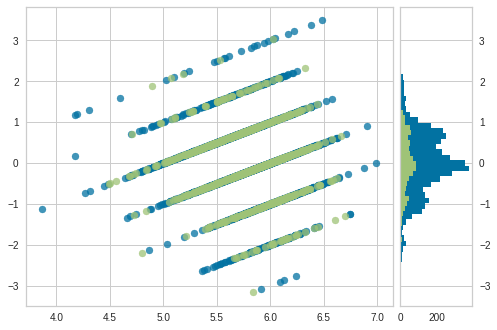

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

Y = dfo["quality"]
X = dfo.drop(columns=['quality'])

# Criando os dados de train e test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Instanciando o modelo linear e o visualizador
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Ajuste os dados de treinamento ao visualizador
visualizer.score(X_test, y_test)  # Avaliando o modelo nos dados de teste

Os resíduos, no contexto dos modelos de regressão, são a diferença entre o valor observado da variável de destino ($ y $) e o valor previsto ($ ŷ $), ou seja, o erro da previsão. 

O gráfico de resíduos mostra a diferença entre os resíduos no eixo vertical e a variável dependente no eixo horizontal, permitindo detectar regiões no destino que podem ser suscetíveis a mais ou menos erros.

Um uso comum do gráfico de resíduos é analisar a variação do erro do regressor. Os pontos são dispersos aleatoriamente em torno do eixo horizontal; um modelo de regressão linear é geralmente apropriado para os dados; caso contrário, um modelo não linear é mais apropriado.

No caso acima, vemos uma distribuição uniforme e aleatória dos resíduos em relação ao alvo em duas dimensões. Isso parece indicar que nosso modelo linear não está funcionando bem. Também podemos ver no histograma que nosso erro é  distribuído em torno de $0,16$, o que geralmente também indica um modelo não está ajustado.

0.04543448588336396

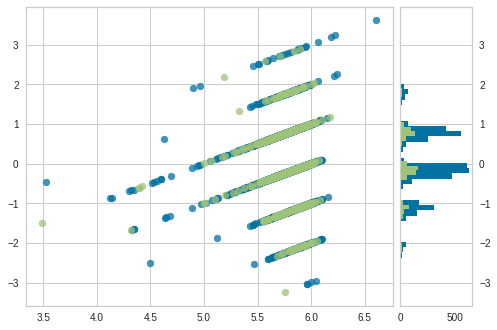

In [30]:
Y = dfo["quality"]
X = dfo.drop(columns=['quality','type','fixed_acidity','volatile_acidity','citric_acid','total_sulfur_dioxide','pH','sulphates'])

# Criando os dados de train e test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Instanciando o modelo linear e o visualizador
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Ajuste os dados de treinamento ao visualizador
visualizer.score(X_test, y_test)  # Avaliando o modelo nos dados de teste

In [0]:
import statsmodels.formula.api as smf
cols = X.columns
formule = " + ".join(map(str, cols))
formule = "quality ~ " + formule

In [32]:
reg = smf.ols(formule, data = dfo)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     56.40
Date:                Wed, 08 Apr 2020   Prob (F-statistic):           2.54e-57
Time:                        21:01:50   Log-Likelihood:                -6729.3
No. Observations:                5320   AIC:                         1.347e+04
Df Residuals:                    5314   BIC:                         1.351e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.0889    

Isso significa que $5%$ da variância de $quality$, é explicada pela variância de $X$. Uma regressão não tem poder suficiente para classificar essa distribuição do tipo multinomial.

**Vamos retornar os valores originais para o tipo de vinho.**

In [0]:
dfo['type'] = dfo['type'].map({1: 'White',2: 'Red'}) 

## Modelagem

Em probabilidade e estatística, a distribuição multinomial é uma generalização da distribuição binomial. A distribuição multinomial dá a probabilidade de qualquer combinação particular de número de sucessos para as diferentes categorias ou classes.

Para selecionar o melhor modelo, usaremos métricas:

* AUC - Calculada como uma área que varia de 0 a 1, mas a interpretação do valor da AUC é uma probabilidade . Probabilidade de que, se fizermos duas observações de nossas previsões, elas serão ordenadas da maneira correta.
* RMSE - Raiz quadrada do erro médio quadrático normalizado. Quanto melhor o ajuste entre os dados gerados pelas estratégias, mais próximo de zero quanto melhor for o ajuste. 
* Acurácia - A pergunta que a acurácia responde é a seguinte: no geral, o quão frequente o classificador está correto?

As outras métricas (F1, Precision, Recall e AIC) são boas para distribuições binomiais e não serão abordadas nesse contexto.


### AutoML: Automatic Machine Learning

A interface do H2O AutoML foi projetada para ter o menor número possível de parâmetros, de modo que tudo que o usuário precisa é apontar para o conjunto de dados, identificar a coluna de resposta e, opcionalmente, especificar uma restrição de tempo ou limite no número total de modelos treinados.

Há outra biblioteca de AutoML. Escolhemos *H2O* por ser parte da **AWS Marketplace** que fornece uma maneira direta de implantar um cluster de VMs com H2O.

Podemos usar tabmém:

O **Auto-sklearn** fornece aprendizado de máquina supervisionado pronto para uso. Construído em torno da biblioteca de aprendizado de máquina do scikit-learn, o auto-sklearn pesquisa automaticamente o algoritmo de aprendizado correto para um novo conjunto de dados de aprendizado de máquina e otimiza seus hiperparâmetros. Assim, libera o praticante de aprendizado de máquina dessas tarefas tediosas e permite que ele se concentre no problema real.

[AUTO-SKLEARN](https://www.automl.org/automl/auto-sklearn/)

H2O foi escolhido aqui por ter maior performance de execução. Já realizei avaliações de desempenho e H2O tem se mostrado mais performático.

### Parsing

O parsing do Data Frame original para o modelo do *H2O* é necessário.

In [34]:
df = h2o.H2OFrame(dfo)

Parse progress: |█████████████████████████████████████████████████████████| 100%


Validando o novo Data Frame

In [35]:
df.head()

type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
White,7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6
White,6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6
White,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6
White,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6
White,6.2,0.32,0.16,7,0.045,30,136,0.9949,3.18,0.47,9.6,6
White,8.1,0.22,0.43,1.5,0.044,28,129,0.9938,3.22,0.45,11,6
White,8.1,0.27,0.41,1.45,0.033,11,63,0.9908,2.99,0.56,12,5
White,8.6,0.23,0.4,4.2,0.035,17,109,0.9947,3.14,0.53,9.7,5
White,7.9,0.18,0.37,1.2,0.04,16,75,0.992,3.18,0.63,10.8,5
White,6.6,0.16,0.4,1.5,0.044,48,143,0.9912,3.54,0.52,12.4,7


### Dividindo os dados em treinamento, validação e teste

O conjunto de **treinamento** contém uma saída conhecida e o modelo aprende sobre esses dados para ser generalizado para outros dados posteriormente. 

Os dados de **validação** serão usados para o ajuste dos parametros do modelo e verificar se o mesmo aprendeu o suficiente.

Os dasos de **teste** são usados para eliminar a chance de overfiting e são usados em última instância.

Temos o conjunto de dados de teste (ou subconjunto) para testar a previsão do nosso modelo nesse subconjunto.

A variável *quality* ou preditora deve ser uma variável do tipo *factor*. Fazemos a conversão aqui.

In [0]:
train, valid, test = df.split_frame(ratios=[0.7, 0.2], seed=1234)


### Os algoritmos que podem ser especificados incluem:

* DRF (incluindo os modelos Random Forest e Extremely Randomized Trees (XRT)
* GLM - Generalized linear model
* XGBoost (XGBoost GBM)
* GBM (H2O GBM) - Gradient boosting
* DeepLearning (rede neural artificial multicamada totalmente conectada)
* StackedEnsemble

In [0]:
from h2o.automl import H2OAutoML, get_leaderboard
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1, include_algos = ["GLM", "DeepLearning", "DRF","xGBoost","StackedEnsemble"])

y = "quality"
x = list(dfo.columns).remove(y)

In [38]:
aml.train(x=x, y=y, training_frame=train,validation_frame=valid)

AutoML progress: |
21:01:53.702: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


### AutoML - Resultado

Os modelos são classificados por uma métrica padrão com base no tipo de problema (a segunda coluna do placar). Nos problemas de classificação binária, essa métrica é *AUC*, e nos problemas de classificação em várias classes, a métrica é o erro médio por classe. 

Em problemas de regressão, a métrica de classificação padrão é desvio.

In [39]:
lb = get_leaderboard(aml, extra_columns='ALL')
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20200408_210153,0.473522,0.688129,0.473522,0.534599,0.103492,1655,0.049413
StackedEnsemble_BestOfFamily_AutoML_20200408_210153,0.490856,0.700611,0.490856,0.543511,0.105367,1579,0.017175
XGBoost_3_AutoML_20200408_210153,0.500855,0.707711,0.500855,0.548642,0.106505,314,0.002534
XGBoost_grid__1_AutoML_20200408_210153_model_2,0.519132,0.720508,0.519132,0.559978,0.108209,813,0.005273
XGBoost_grid__1_AutoML_20200408_210153_model_1,0.523174,0.723308,0.523174,0.563729,0.108665,674,0.004689
XGBoost_2_AutoML_20200408_210153,0.54251,0.736553,0.54251,0.573016,0.110371,606,0.003595
XGBoost_grid__1_AutoML_20200408_210153_model_3,0.588511,0.767145,0.588511,0.592541,0.115341,3039,0.011689
GLM_1_AutoML_20200408_210153,0.65238,0.807701,0.65238,0.621994,0.120767,220,0.001057
XRT_1_AutoML_20200408_210153,0.697875,0.835389,0.697875,0.628614,0.124913,339,0.003088
DeepLearning_1_AutoML_20200408_210153,0.71068,0.843018,0.71068,0.650221,0.127131,385,0.007335


### O vencedor

O XGBoost é um algoritmo de aprendizado supervisionado que implementa um processo chamado impulso para gerar modelos precisos. Impulsionar refere-se à técnica de aprendizado por conjunto de construção de vários modelos sequencialmente, com cada novo modelo tentando corrigir as deficiências no modelo anterior. No aumento de árvore, cada novo modelo adicionado ao conjunto é uma árvore de decisão. O XGBoost fornece aumento de árvore paralelo (também conhecido como GBDT, GBM) que resolve muitos problemas de ciência de dados de maneira rápida e precisa. Para muitos problemas, o XGBoost é uma das melhores estruturas da máquina de aumento de gradiente (GBM) atualmente.

[Os modelos XGBoost dominam muitas competições do Kaggle.](https://www.kaggle.com/dansbecker/xgboost)

[Veja mais detalhes aqui](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html)

[AWS](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/cloud-integration/aws.html)

## Stacked Ensembles

[AWS H2O](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/stacked-ensembles.html?highlight=stackedensemble)

O **Stacking**, também chamado de **Super Learning** ou **Stacked Regression**, é uma classe de algoritmos que envolve o treinamento de um "aprendiz de metal" de segundo nível para encontrar a combinação ideal dos alunos de base. Ao contrário do ensacamento e do reforço, o objetivo do empilhamento é reunir conjuntos fortes e diversos de alunos.

**Sklearn também tem**

[sklearn.ensemble.StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

Stacked generalization consiste em empilhar a saída do estimador individual e usar um classificador para calcular a previsão final. O empilhamento permite usar a força de cada estimador individual usando sua saída como entrada de um estimador final.



In [40]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from __future__ import print_function
h2o.init()


# Identificar preditores e resposta
x = train.columns
y = "quality"
x.remove(y)

# Para classificação binária, a resposta deve ser um factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Número de folds (para gerar dados de nível um para stacking)
nfolds = 5

# Existem algumas maneiras de montar uma lista de modelos para stacking:
# 1. Treine modelos individuais e coloque-os em uma lista
# 2. Treine uma grade de modelos
# 3. Treine várias grades de modelos <<=
# Nota: Todos os modelos de base devem ter as mesmos números de folds 
# de validação cruzada e os valores previstos de cross-validation 
# devem ser mantidos.


# 1. Gerando 2-model ensemble (GBM + RF)

# Train e cross-validate para um GBM
my_gbm = H2OGradientBoostingEstimator(distribution="multinomial",
                                      ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x=x, y=y, training_frame=train)


# Train e cross-validate para um RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x=x, y=y, training_frame=train)


# Train um stacked ensemble usando o GBM e  GLM abaixo
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_multinomial",
                                       base_models=[my_gbm, my_rf])
ensemble.train(x=x, y=y, training_frame=train)

# Avaliando o desempenho do conjunto nos dados de teste
perf_stack_test = ensemble.model_performance(test)



Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 mins 11 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_aqm1ql
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.174 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [0]:
# Avaliando o desempenho do conjunto nos dados de teste
perf_stack_test = ensemble.model_performance(test)

# Comparando com o desempenho básico do learner no conjunto de testes
perf_gbm_test = my_gbm.model_performance(test)
perf_rf_test = my_rf.model_performance(test)

Recuperando o erro médio por classe em todas as classes.

É o erro médio por classe (apenas na classificação de várias classes) é a média dos erros de cada classe no seu conjunto de dados de várias classes. Essa métrica refere-se à classificação incorreta dos dados nas classes.

In [42]:
perf_gbm_test.mean_per_class_error()

0.754377938358377

**AUC**

A AUC é calculada como uma área que varia de 0 a 1, mas a interpretação do valor da AUC é uma probabilidade . Probabilidade de que, se fizermos duas observações de nossas previsões, elas serão ordenadas da maneira correta.


In [43]:
baselearner_best_auc_test = max(perf_gbm_test.mean_per_class_error(), perf_rf_test.mean_per_class_error())
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))

Best Base-learner Test AUC:  0.754377938358377


In [44]:
perf_gbm_test.confusion_matrix()


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,3,4,5,6,7,8,9,Error,Rate
0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.000000,4 / 4
1,0.0,1.0,12.0,11.0,0.0,0.0,0.0,0.958333,23 / 24
2,1.0,1.0,118.0,68.0,1.0,0.0,0.0,0.375661,71 / 189
3,0.0,0.0,47.0,185.0,9.0,0.0,0.0,0.232365,56 / 241
4,0.0,0.0,2.0,52.0,22.0,0.0,1.0,0.714286,55 / 77
5,0.0,0.0,1.0,11.0,4.0,0.0,0.0,1.000000,16 / 16
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,1 / 1
7,1.0,3.0,181.0,330.0,36.0,0.0,1.0,0.409420,226 / 552


In [45]:
print("Best Base-learner Acurácia:",perf_gbm_test.confusion_matrix()[7][7])

Best Base-learner Acurácia: 0.40942028985507245


Apesar do balanceamento para o treinamento, o modelo parece ter falhado ao ser submetido a uma validação.

In [46]:
# 2. Gere uma grade aleatória de modelos e empilhando-os

# Specify GBM hyperparameters for the grid
hyper_params = {"learn_rate": [0.01, 0.03], # Taxa de aprendizado, + arvores - overfitting
                "max_depth": [3, 4, 5, 6, 9], # profundidade máxima em que cada árvore será construída
                "sample_rate": [0.7, 0.8, 0.9, 1.0], # taxa de amostragem da linha (eixo x) (sem substituição)
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]} # taxa de amostragem da coluna (eixo y) (sem substituição)
                
search_criteria = {"strategy": "RandomDiscrete", "max_models": 3, "seed": 1}

# Train e grid
grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid")
grid.train(x=x, y=y, training_frame=train)

# Train um stacked ensemble usando o GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm",
                                       base_models=grid.model_ids)
ensemble.train(x=x, y=y, training_frame=train)

# Avaliando o desempenho do conjunto nos dados de teste
perf_stack_test = ensemble.model_performance(test)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [47]:
# Comparando com o desempenho básico do learner no conjunto de testes
baselearner_best_auc_test = max([h2o.get_model(model).model_performance(test).rmse() for model in grid.model_ids])
stack_auc_test = perf_stack_test.rmse()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

Best Base-learner Test AUC:  0.8290242093045351
Ensemble Test AUC:  0.6834603249547286


## Abordagem Tradicional

Vamos usar aqui o processamento manual para avaliar as diferenças.

### Balanceamento de Classes

O parâmetro **balance_classes=True** no código abaixo fornece suporte para a amostra que temos com classes desbalanceadas.

In [0]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# função para configurar parâmetros para trabalhar com o modelo H2O xGBoost
def setDRFParam(ntrees=200,                   # número de árvores a serem construídas no modelo
                max_depth=20,                 # profundidade máxima em que cada árvore será construída
                balance_classes=True,         # pode ser usada para equilibrar a distribuição de classes
                sample_rate=0.75,             # usado para especificar a taxa de amostragem da linha (eixo x) (sem substituição)
                col_sample_rate_per_tree=0.8, # especifica a taxa de amostragem da coluna para cada árvore (sem substituição))
                min_rows=5,                   # número mínimo de observações para uma folha para dividir
                seed=3333,                    # random number generator (RNG)
                score_tree_interval=5,        # parada antecipada e tentativa de tornar a parada antecipada reproduzível
                calibrate_model=False,        # especificação da escala de Platt no DRF para probabilidades de classe calibradas
                categorical_encoding="one_hot_explicit", # esquema de codificação a ser usado para lidar com recursos categóricos
                distribution="multinomial",     # no nosso caso, a coluna de resposta deve ser categórica de n classes
                fold_assignment="Stratified", # validação cruzada - é melhor para grandes conjuntos de dados = auto = random
                histogram_type="auto",        # é comumente usado para acelerar o processo de k-fold
                keep_cross_validation_predictions=True, # A validação cruzada N-fold é usada para validar um modelo internamente
                nfolds=5):
   
        param = {
              "ntrees" : ntrees                                      
            , "max_depth" : max_depth                                
            , "balance_classes" : balance_classes                    
            , "sample_rate" : sample_rate
            , "col_sample_rate_per_tree" : col_sample_rate_per_tree
            , "min_rows" : min_rows
            , "seed": seed
            , "score_tree_interval": score_tree_interval
            , "calibrate_model": calibrate_model
            , "categorical_encoding": categorical_encoding
            , "distribution": distribution
            , "fold_assignment": fold_assignment
            , "histogram_type": histogram_type
            , "nfolds": nfolds
        }
        return(param)

### Validação Cruzada

A validação cruzada é uma técnica para avaliar a capacidade de generalização de um modelo, a partir de um conjunto de dados. Esta técnica é amplamente empregada em problemas onde o objetivo da modelagem é a predição. 

O método de validação cruzada denominado $k-fold$ consiste em dividir o conjunto total de dados em k subconjuntos mutuamente exclusivos do mesmo tamanho e, a partir daí, um subconjunto é utilizado para teste e os $k-1$ restantes são utilizados para estimação dos parâmetros, fazendo-se o cálculo da acurácia do modelo. Este processo é realizado $k$ vezes alternando de forma circular o subconjunto de teste. 

Nesse experimento usamos $K$ com o valor de $5$, pois a quantidade de observações é pequena.

[Wikipédia](https://pt.wikipedia.org/wiki/Valida%C3%A7%C3%A3o_cruzada)

In [0]:
df['quality'] = df['quality'].asfactor()
train, valid = df.split_frame(ratios= [.7], seed = 1234)
response = 'quality'
predictors = df.columns
histogram_type = 'auto'
categorical_encoding = 'auto'


### Numero de arvores

Alterando o parâmetro *ntrees* para $50$ e *max_depth* para $20$

Para algoritmos baseados em árvore, esta opção especifica o número de árvores a serem construídas no modelo. Nos modelos baseados em árvore, cada nó na árvore corresponde a um campo de recurso de um conjunto de dados. Exceto pelo nó superior, cada nó tem uma ramificação de entrada. Da mesma forma, exceto no nó inferior (ou nó folha), cada nó possui um número de ramificações de saída. Uma ramificação representa um valor possível para o campo de entrada do conjunto de dados de origem. Uma folha representa o valor do campo objetivo, dados todos os valores para cada campo de entrada na cadeia de ramificações que vão da raiz (superior) para essa folha.

In [50]:
param = setDRFParam(ntrees=50, max_depth=20,histogram_type=histogram_type,categorical_encoding=categorical_encoding)
model_xGBoost50 = H2OGradientBoostingEstimator(**param)
model_xGBoost50.train(x=predictors, y=response, training_frame=train,validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Alterando o parâmetro *ntrees* para $200$ e *max_depth* para $40$

Podemos tentar muitas configurações usando um loop para muitos valores, começando em $50$ a $600$ para ver quais são os melhores resultados. 

Por enquanto, neste experimento, tentamos apenas dois.

In [51]:
param = setDRFParam(ntrees=200, max_depth=10,histogram_type=histogram_type,categorical_encoding=categorical_encoding)
model_xGBoost200 = H2OGradientBoostingEstimator(**param)
model_xGBoost200.train(x=predictors, y=response, training_frame=train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### Salvando os modelos para ter acesso posterior

Ao salvar um modelo binário de H2O com *h2o.save_model* ou no Flow, você só poderá carregar e usar esse modelo binário salvo com a mesma versão do H2O usada para treinar seu modelo.

Isso é importante, pois se treinarmos vários modelos poderemos acessar interativamente esse modelos e analisar de forma comparativa, como veremos mais abaixo. 

Podemos inclusive criar históricos de modelos ao longo de sua evolução. 


In [0]:
import os

model_path = h2o.save_model(model=model_xGBoost50, path='.', force=True)
os.rename(model_path,os.path.split(model_path)[0]+'/xGBoost50')
model_path = h2o.save_model(model=model_xGBoost200, path='.', force=True)
os.rename(model_path,os.path.split(model_path)[0]+'/xGBoost200')


In [0]:
def showModel(modelImp,Var_Importance,Confusion_Matrix,Hit_Ratio,Range,Plot_Metric):
    model = h2o.load_model(modelImp)
    baselearner_best_auc_test = max([h2o.get_model(model).model_performance(test).rmse() for model in grid.model_ids])
    stack_auc_test = perf_stack_test.rmse()
    print("Model : {0} ".format(modelImp))
    print("AUC: {0}".format(model.confusion_matrix(valid)[7][7]))

    if Confusion_Matrix:
        print(model.confusion_matrix(valid))

    if Var_Importance:
        model.varimp_plot()
    else:
        varimpDF = model.varimp(True)
        print(varimpDF[varimpDF['scaled_importance'] >= Range])

    if Hit_Ratio:
        print(model.hit_ratio_table(valid=True))

    if Plot_Metric:
        model.plot(metric="AUTO", timestep="AUTO")
        

In [0]:
models = ['xGBoost50','xGBoost200']

### Desempenho do Modelo

O H2O-3 fornece uma variedade de métricas que podem ser usadas para avaliar modelos supervisionados e não supervisionados. 

As métricas desta seção cobrem apenas modelos de aprendizado supervisionado, que variam com base no tipo de modelo (classificação ou regressão). No momento, mostramos apenas o desempenho da classificação, que é o nosso foco.



### Usando o Interact

A função de interação (ipywidgets.interact) cria automaticamente controles da interface do usuário (UI) para explorar códigos e dados de maneira interativa. É a maneira mais fácil de começar a usar os widgets do IPython.

In [55]:
interact(showModel,modelImp=models,
         Var_Importance=True,
         Confusion_Matrix=False,
         Cross_Validation=False,
         Hit_Ratio=False,
         Range=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1),
         Plot_Metric=False)

interactive(children=(Dropdown(description='modelImp', options=('xGBoost50', 'xGBoost200'), value='xGBoost50')…

<function __main__.showModel>

## Conclusão

Veja no documento clicando [aqui](https://github.com/dbranquinho/wine/blob/master/LopesBin.ipynb)